In [ ]:
# Importation des bibliothèques nécessaires
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modèles et évaluation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, label_binarize
from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, confusion_matrix,
    f1_score, recall_score, roc_auc_score, roc_curve
)

# Gestion du déséquilibre des classes
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Pour sauvegarder le modèle
import joblib


In [ ]:
# Accès à Google Drive (pour Google Colab)
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
# Chargement des fichiers CSV depuis Google Drive
folder_path = '/content/drive/MyDrive/data/'

files = [
    'Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv',
    'Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv',
    'Friday-WorkingHours-Morning.pcap_ISCX.csv',
    'Monday-WorkingHours.pcap_ISCX.csv',
    'Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv',
    'Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv',
    'Tuesday-WorkingHours.pcap_ISCX.csv',
    'Wednesday-workingHours.pcap_ISCX.csv'
]


In [ ]:
# Fusion des datasets
dfs = [pd.read_csv(folder_path + file) for file in files]
df = pd.concat(dfs, ignore_index=True)
print("Shape:", df.shape)


Shape: (2830743, 79)


In [ ]:
#  Nettoyage : suppression des doublons
df.drop_duplicates(inplace=True)
# Remplacement des valeurs infinies par NaN
df.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Remplissage des valeurs manquantes pour les colonnes numériques avec la moyenne
numeric_columns = df.select_dtypes(include=[np.number]).columns
df[numeric_columns] = df[numeric_columns].fillna(df[numeric_columns].mean())

# Pour les colonnes non numériques : remplissage avec la valeur la plus fréquente (mode)
non_numeric_columns = df.select_dtypes(exclude=[np.number]).columns
for col in non_numeric_columns:
    df[col] = df[col].fillna(df[col].mode()[0])
# Suppression finale des lignes encore incomplètes
df.dropna(inplace=True)


In [ ]:
# Suppression de certaines colonnes jugées peu informatives
columns_to_drop = [
    ' Destination Port',
    ' Fwd PSH Flags', ' Bwd PSH Flags',
    ' Fwd URG Flags', ' Bwd URG Flags',
    ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate',
    ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk',
    ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes',
    ' Idle Std', ' Idle Max', ' Idle Min'
]

columns_to_drop_filtered = [col for col in columns_to_drop if col in df.columns]
df.drop(columns=columns_to_drop_filtered, inplace=True)
print(f"Colonnes supprimées : {columns_to_drop_filtered}")


Colonnes supprimées : [' Destination Port', ' Bwd PSH Flags', ' Fwd URG Flags', ' Bwd URG Flags', ' Fwd Avg Packets/Bulk', ' Fwd Avg Bulk Rate', ' Bwd Avg Bytes/Bulk', ' Bwd Avg Packets/Bulk', ' Subflow Fwd Bytes', ' Subflow Bwd Packets', ' Subflow Bwd Bytes', ' Idle Std', ' Idle Max', ' Idle Min']


In [ ]:
# Encodage de la variable cible ' Label'
le = LabelEncoder()
df[' Label'] = le.fit_transform(df[' Label'])
print("Mapping des classes :", dict(zip(le.classes_, le.transform(le.classes_))))

Mapping des classes : {'BENIGN': np.int64(0), 'Bot': np.int64(1), 'DDoS': np.int64(2), 'DoS GoldenEye': np.int64(3), 'DoS Hulk': np.int64(4), 'DoS Slowhttptest': np.int64(5), 'DoS slowloris': np.int64(6), 'FTP-Patator': np.int64(7), 'Heartbleed': np.int64(8), 'Infiltration': np.int64(9), 'PortScan': np.int64(10), 'SSH-Patator': np.int64(11), 'Web Attack � Brute Force': np.int64(12), 'Web Attack � Sql Injection': np.int64(13), 'Web Attack � XSS': np.int64(14)}


In [ ]:
# Séparation des features (X) et de la cible (y)
X = df.drop(' Label', axis=1)  # Variables indépendantes
y = df[' Label']  # Variable cible

In [ ]:
# Sélection de features avec faible variance
selector = VarianceThreshold(threshold=0.01)
X = selector.fit_transform(X)


In [ ]:
# Séparation en données d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

In [ ]:
# Undersampling des classes majoritaires (ex: classe 0 → 30 000)
rus = RandomUnderSampler(sampling_strategy={0: 30000}, random_state=42)
X_under, y_under = rus.fit_resample(X_train, y_train)
# Oversampling (SMOTE) des classes minoritaires
sm = SMOTE(random_state=42)
X_final, y_final = sm.fit_resample(X_under, y_under)

In [ ]:
class_weights = {
    0: 1,
    1: 10,
    2: 1,
    3: 1,
    4: 1,
    5: 1,
    6: 1,
    7: 1,
    8: 1,
    9: 1,
    10: 1,
    11: 1,
    12: 6,
    13: 4,
    14: 6
}

In [ ]:
#  Initialisation du modèle Random Forest
model_rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    min_samples_leaf=1,
    random_state=42,
    n_jobs=-1,
    class_weight=class_weights  # Important pour gérer les classes déséquilibrées
)


In [ ]:
# Mesure du temps d'entraînement
import time
start_train = time.time()
model_rf.fit(X_final,y_final)
end_train = time.time()
training_time = end_train - start_train
print("Temps d'entraînement (s) :", training_time)

Temps d'entraînement (s) : 977.6534504890442


In [ ]:
# Mesure du temps de prédiction
start_pred = time.time()
y_pred = model_rf.predict(X_test)
end_pred = time.time()
prediction_time = end_pred - start_pred
print("Temps de prédiction (s) :", prediction_time)

Temps de prédiction (s) : 5.569016456604004


In [ ]:
# Accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.9936607112769167


In [ ]:
# F1 Scores
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')
print("F1 Score (macro):", f1_macro)
print("F1 Score (weighted):", f1_weighted)

F1 Score (macro): 0.8443309782093791
F1 Score (weighted): 0.994626818078251


In [ ]:
# Recall (sensibilité)
recall_macro = recall_score(y_test, y_pred, average='macro')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
print("Recall (macro):", recall_macro)
print("Recall (weighted):", recall_weighted)


Recall (macro): 0.9184675963187949
Recall (weighted): 0.9936607112769167


In [ ]:
#  Rapport de classification complet
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))


📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      1.00    419297
           1       0.24      0.97      0.39       391
           2       1.00      1.00      1.00     25603
           3       0.97      1.00      0.98      2057
           4       0.98      1.00      0.99     34570
           5       0.89      0.99      0.94      1046
           6       0.97      0.99      0.98      1077
           7       0.98      1.00      0.99      1187
           8       1.00      1.00      1.00         2
           9       0.83      0.71      0.77         7
          10       0.99      1.00      0.99     18164
          11       0.99      0.99      0.99       644
          12       0.35      0.65      0.46       294
          13       0.80      1.00      0.89         4
          14       0.23      0.47      0.30       130

    accuracy                           0.99    504473
   macro avg       0.81      0.92      0.84    504473

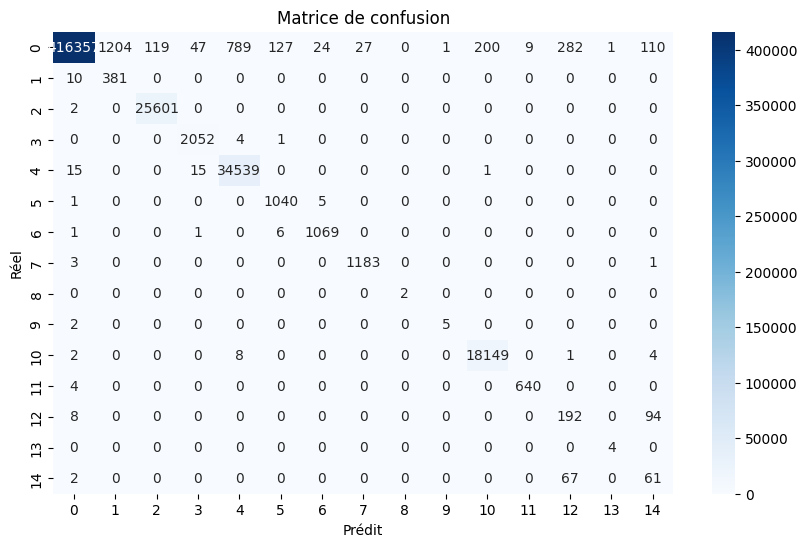

In [ ]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Matrice de confusion")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.show()

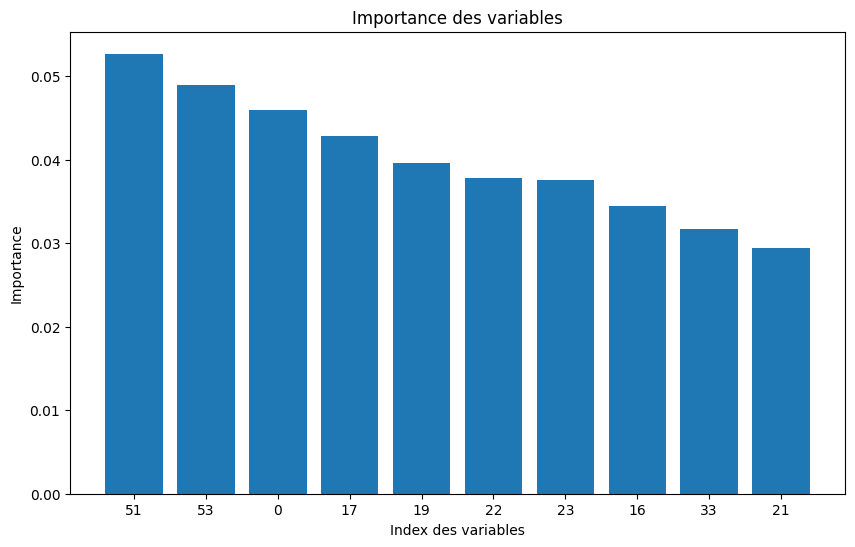

In [ ]:
# Visualisation de l’importance des 10 variables les plus importantes
importances = model_rf.feature_importances_
indices = np.argsort(importances)[::-1]
plt.figure(figsize=(10, 6))
plt.title("Importance des variables")
plt.bar(range(10), importances[indices[:10]], align='center')
plt.xticks(range(10), indices[:10])
plt.xlabel("Index des variables")
plt.ylabel("Importance")
plt.show()


In [ ]:
# AUC-ROC Score (multi-class)
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = model_rf.predict_proba(X_test)
auc_score = roc_auc_score(y_test_bin, y_pred_proba, multi_class='ovr')
print("AUC-ROC Score (multi-class):", auc_score)

AUC-ROC Score (multi-class): 0.9909818250174596


In [ ]:
# Sauvegarder le modèle
joblib.dump(model_rf, 'random_forest_model.pkl')
print(" Modèle sauvegardé sous le nom : random_forest_model.pkl")

✅ Modèle sauvegardé sous le nom : random_forest_model.pkl
